[INFO] [1731359329.313473377] [rosbag2_storage]: Opened database '/home/rgautham20/lab4/data_driving.bag/data_driving.bag_0.db3' for READ_ONLY.


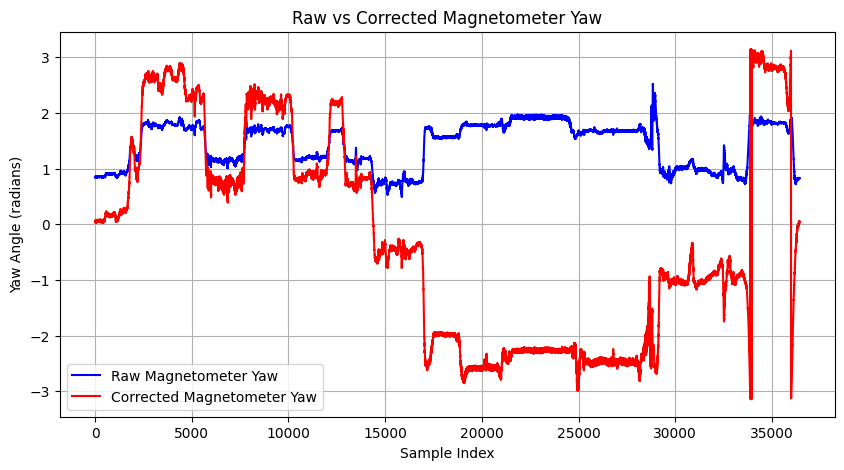

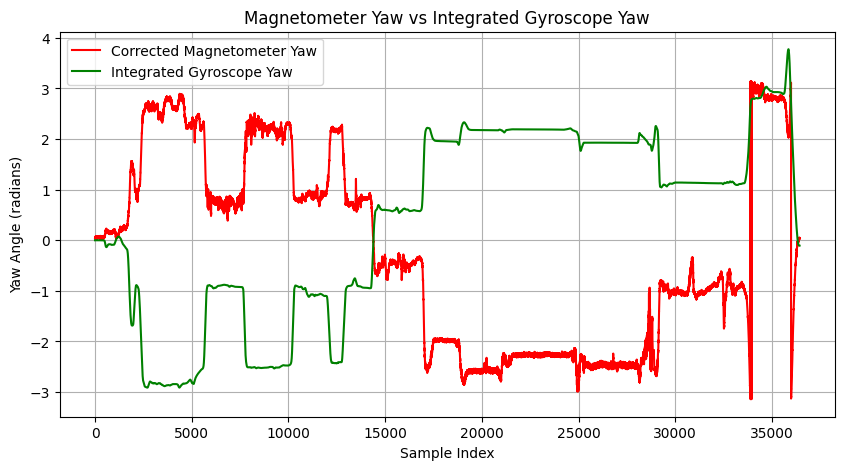

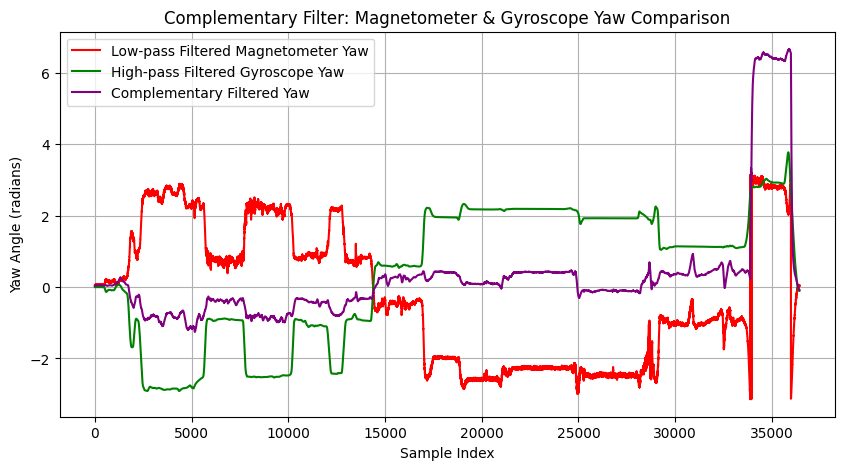

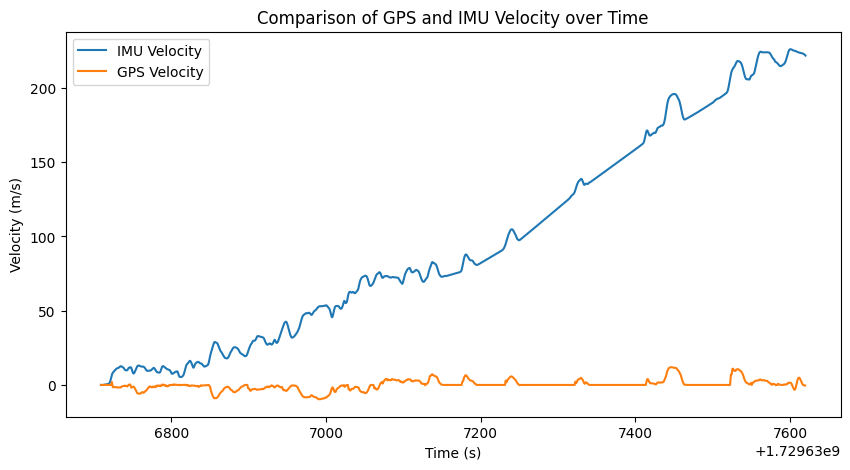

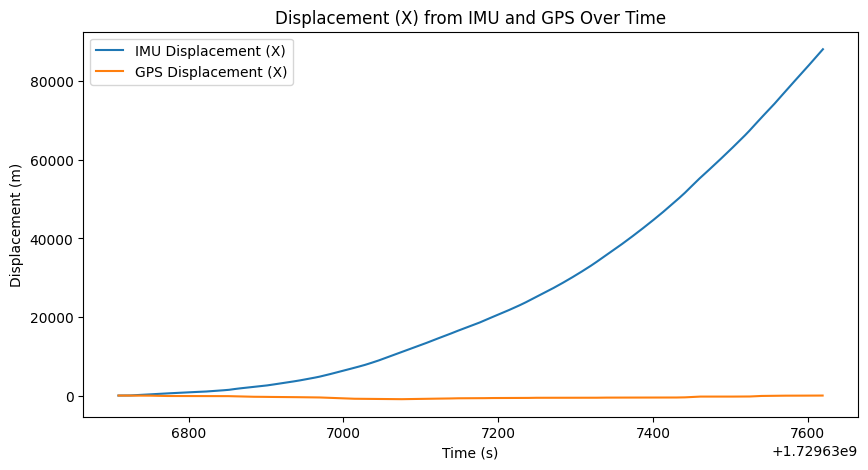

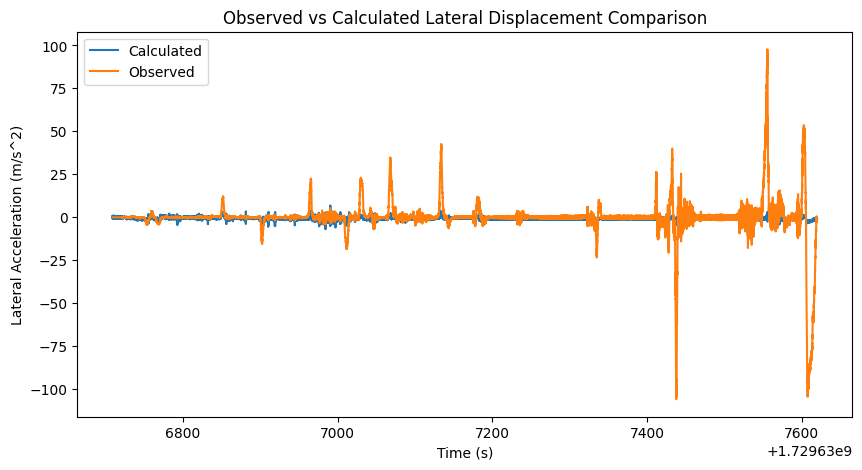

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.signal import butter, filtfilt
from gps_interfaces.msg import GPSmsg
from imu_interfaces.msg import IMUmsg
from rclpy.serialization import deserialize_message
import rosbag2_py
from rosidl_runtime_py.utilities import get_message

# Complementary filter parameter
ALPHA = 0.98  # Weight for gyroscope data in complementary filter

def load_bag_data(bagfile_path):
    """
    Load IMU and GPS data from a ROS2 bag file.
    """
    storage_options = rosbag2_py.StorageOptions(uri=bagfile_path, storage_id="sqlite3")
    converter_options = rosbag2_py.ConverterOptions(input_serialization_format="cdr", output_serialization_format="cdr")
    reader = rosbag2_py.SequentialReader()
    reader.open(storage_options, converter_options)

    imu_data = []
    gps_data = []
    while reader.has_next():
        topic, data, _ = reader.read_next()
        if topic == "/imu":
            imu_msg = deserialize_message(data, IMUmsg)
            imu_data.append(imu_msg)
        elif topic == "/gps":
            gps_msg = deserialize_message(data, GPSmsg)
            gps_data.append(gps_msg)
    
    return imu_data, gps_data

def apply_filter(data, cutoff, fs, filter_type="low"):
    """
    Apply a low-pass or high-pass Butterworth filter to the data.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(N=1, Wn=normal_cutoff, btype=filter_type, analog=False)
    return filtfilt(b, a, data)

def compute_yaw_from_magnetometer(mag_data):
    """
    Compute the yaw angle from magnetometer data with static calibration.
    """
    bias = np.mean(mag_data, axis=0)
    corrected_mag_data = mag_data - bias
    raw_yaw = np.arctan2(mag_data[:, 1], mag_data[:, 0])
    corrected_yaw = np.arctan2(corrected_mag_data[:, 1], corrected_mag_data[:, 0])
    return raw_yaw, corrected_yaw

def apply_complementary_filter(gyro_yaw, corrected_yaw_mag, imu_time):
    """
    Apply a complementary filter to fuse yaw estimates from gyroscope and magnetometer.
    """
    complementary_yaw = [corrected_yaw_mag[0]]
    for i in range(1, len(corrected_yaw_mag)):
        dt = imu_time[i] - imu_time[i - 1]
        gyro_yaw_estimate = complementary_yaw[-1] + gyro_yaw[i] * dt
        combined_yaw = ALPHA * gyro_yaw_estimate + (1 - ALPHA) * corrected_yaw_mag[i]
        complementary_yaw.append(combined_yaw)
    return np.array(complementary_yaw)

def integrate_velocity(accel_data, imu_time):
    """
    Integrate acceleration to get velocity, applying a bias correction.
    """
    cutoff_frequency = 0.25
    fs = 1.0 / np.mean(np.diff(imu_time))
    filtered_acceleration = apply_filter(accel_data, cutoff_frequency, fs)
    acceleration_bias = np.mean(filtered_acceleration[:100])
    corrected_acceleration = (filtered_acceleration - acceleration_bias) * 1.5
    return cumulative_trapezoid(corrected_acceleration, imu_time, initial=0)

def process_data(bagfile_path):
    """
    Main function to process the bag file, apply bias correction, and generate plots.
    """
    # Load data from bag file
    imu_data, gps_data = load_bag_data(bagfile_path)

    # Extract IMU and GPS timestamps
    imu_time = [msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9 for msg in imu_data]
    gps_time = np.array([msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9 for msg in gps_data])

    # Extract and process yaw angles
    gyro_data = np.array([msg.imu.angular_velocity.z for msg in imu_data])
    mag_data = np.array([[msg.mag_field.magnetic_field.x, msg.mag_field.magnetic_field.y] for msg in imu_data]) * 1e6

    # Yaw calculations
    raw_yaw_mag, corrected_yaw_mag = compute_yaw_from_magnetometer(mag_data)
    time_deltas = np.diff(imu_time)
    yaw_gyro = cumulative_trapezoid(gyro_data, dx=time_deltas, initial=0)
    complementary_yaw = apply_complementary_filter(yaw_gyro, corrected_yaw_mag, imu_time)

    # Velocity and displacement calculations
    linear_acceleration = np.array([msg.imu.linear_acceleration.x for msg in imu_data])
    lateral_acceleration = np.array([msg.imu.linear_acceleration.y for msg in imu_data])  # Lateral acceleration
    imu_velocity = integrate_velocity(linear_acceleration, imu_time)

    # GPS velocity and displacement
    utm_eastings = np.array([msg.utm_easting for msg in gps_data])
    unique_gps_times, unique_indices = np.unique(gps_time, return_index=True)
    utm_eastings = utm_eastings[unique_indices]
    gps_velocity = np.diff(utm_eastings) / np.diff(unique_gps_times)
    gps_velocity = np.concatenate(([0], gps_velocity))
    gps_displacement = utm_eastings - utm_eastings[0]

    # Lateral velocity (omega * velocity)
    omega_velocity = gyro_data * imu_velocity

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(raw_yaw_mag, label='Raw Magnetometer Yaw', color='b')
    plt.plot(corrected_yaw_mag, label='Corrected Magnetometer Yaw', color='r')
    plt.title('Raw vs Corrected Magnetometer Yaw')
    plt.xlabel('Sample Index')
    plt.ylabel('Yaw Angle (radians)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(corrected_yaw_mag, label='Corrected Magnetometer Yaw', color='r')
    plt.plot(yaw_gyro, label='Integrated Gyroscope Yaw', color='g')
    plt.title('Magnetometer Yaw vs Integrated Gyroscope Yaw')
    plt.xlabel('Sample Index')
    plt.ylabel('Yaw Angle (radians)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(corrected_yaw_mag, label='Low-pass Filtered Magnetometer Yaw', color='r')
    plt.plot(yaw_gyro, label='High-pass Filtered Gyroscope Yaw', color='g')
    plt.plot(complementary_yaw, label='Complementary Filtered Yaw', color='purple')
    plt.title('Complementary Filter: Magnetometer & Gyroscope Yaw Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('Yaw Angle (radians)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(imu_time, imu_velocity, label="IMU Velocity")
    plt.plot(unique_gps_times, gps_velocity, label="GPS Velocity")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.title("Comparison of GPS and IMU Velocity over Time")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    imu_displacement = cumulative_trapezoid(imu_velocity, imu_time, initial=0)
    plt.plot(imu_time, imu_displacement, label="IMU Displacement (X)")
    plt.plot(unique_gps_times, gps_displacement, label="GPS Displacement (X)")
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Displacement (X) from IMU and GPS Over Time")
    plt.legend()
    plt.show()

    # Observed vs Calculated Lateral Displacement Plot
    plt.figure(figsize=(10, 5))
    plt.plot(imu_time, lateral_acceleration, label="Calculated")
    plt.plot(imu_time, omega_velocity, label="Observed")
    plt.xlabel("Time (s)")
    plt.ylabel("Lateral Acceleration (m/s^2)")
    plt.title("Observed vs Calculated Lateral Displacement Comparison")
    plt.legend()
    plt.show()

# Path to the bag file
bagfile_path = "/home/rgautham20/lab4/data_driving.bag/data_driving.bag_0.db3"
process_data(bagfile_path)